### Informacje dotyczące pomiarów:

* Pomiary czasu dla funkcji odwracania uwzględniają czasy działania algorytmu mnożenia macierzy (tutaj Binet)
* Pomiary czasu dla funckji eliminacji Gaussowskiej uwzględniają czasy działania algorytmów odwracania macierzy i mnożenia macierzy
* W ramach zliczania operacji zmiennoprzecnikowych zliczano operacje na macierzach
* Pliki .csv zawierające pomiary egzekucji algorytmów na maszynie z procesorem i5 13-400f będą nazywane <nazwa_algorytmu>_results_i5_13400f.csv

### Przygotowanie importów do przetworzenia wyników:

Poniższą komórkę wystarczy uruchomić jeden raz.

In [21]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("StatsPlots")

   Resolving package versions...
  No Changes to `C:\Users\Jan\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Jan\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Jan\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Jan\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Jan\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Jan\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Jan\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Jan\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
   Installed StatsFuns ─────────────── v1.3.2
   Installed IntelOpenMP_jll ───────── v2024.2.1+0
   Installed PDMats ────────────────── v0.11.31
   Installed HypergeometricFunctions ─ v0.3.24
   Installed FFTW ──────────────────── v1.8.0
   Installed OffsetArrays ───────

In [22]:
using CSV
using DataFrames
using Plots
using LinearAlgebra
using StatsPlots

##### Zakres generowania liczb losowych:

In [3]:
low = 0.00000001
high = 1.0;

##### Algorytm do porównywania identyczności macierzy:

In [15]:
error_eps = 1e-8

function are_equal(A,B)
    if !all(size(A) .== size(B))
        return false
    end
    return all(abs.(A-B) .< error_eps)
end;

##### Algorytm do generowania macierzy o losowych elementach:

In [5]:
function generate_random_matrix(m,n,a,b)
    A = zeros(m,n)
    for i in 1:m 
        for j in 1:n
            A[i,j] = a + (b-a)*rand()
        end
    end
    return A
end;

Implementacja funkcji Binet'a (pisana w ramch poprzedniego laboratorium), która posłuży do rekurencyjnego mnożenia macierzy.

Zdecydowano się na użycie tej funkcji ze względu na fakt, że jej wydajność czasowa nie ulega znacznym pogorszeniom przy zwiększaniu krawędzi macierzy z wartości $2^n$ do $2^{n+1}$, gdzie $n$ to dowolna liczba naturalna, oraz fakt, że Binet'em można w miarę prosty sposób mnożyć macierze, które się kwadratowe i różnią się dokładnymi kształtami.

In [6]:
function binet(A,B)
    if size(A)[2] != size(B)[1]
        return [[], 0, 0]  
    end    
    overall_number_of_additions = 0
    overall_number_of_multiplications = 0

    function internal_binet(A_,B_)
        m = size(A_)[1]
        n = size(A_)[2]
        p = size(B_)[2]
        if m == 1 && n == 1 && p == 1
            return reshape([A_[1,1]*B_[1,1]],1,1)
        elseif m > 1 && n > 1 && p > 1
            floor_m = div(m,2)
            floor_n = div(n,2)
            floor_p = div(p,2)
            A_11 = A_[1:floor_m , 1:floor_n]
            A_12 = A_[1:floor_m , floor_n+1:end]
            A_21 = A_[floor_m+1:end , 1:floor_n]        
            A_22 = A_[floor_m+1:end , floor_n+1:end]
            B_11 = B_[1:floor_n , 1:floor_p]
            B_12 = B_[1:floor_n , floor_p+1:end]
            B_21 = B_[floor_n+1:end , 1:floor_p]
            B_22 = B_[floor_n+1:end , floor_p+1:end]
            upper = [internal_binet(A_11,B_11)+internal_binet(A_12,B_21) internal_binet(A_11,B_12)+internal_binet(A_12,B_22)]
            lower = [internal_binet(A_21,B_11)+internal_binet(A_22,B_21) internal_binet(A_21,B_12)+internal_binet(A_22,B_22)]
            overall_number_of_additions += 4
            overall_number_of_multiplications += 8
            return [upper ; lower]
        elseif m == 1 && n > 1 && p > 1
            floor_n = div(n,2)
            floor_p = div(p,2)
            A_11 = A_[1:end , 1:floor_n]
            A_12 = A_[1:end , floor_n+1:end]
            B_11 = B_[1:floor_n , 1:floor_p]
            B_12 = B_[1:floor_n , floor_p+1:end]
            B_21 = B_[floor_n+1:end , 1:floor_p]
            B_22 = B_[floor_n+1:end , floor_p+1:end]
            overall_number_of_additions += 2
            overall_number_of_multiplications += 4
            return [internal_binet(A_11,B_11)+internal_binet(A_12,B_21) internal_binet(A_11,B_12)+internal_binet(A_12,B_22)]
        elseif m == 1 && n == 1 && p > 1
            floor_p = div(p,2)
            B_11 = B_[1:end , 1:floor_p]
            B_12 = B_[1:end , floor_p+1:end]
            overall_number_of_multiplications += 2
            return [internal_binet(A_,B_11) internal_binet(A_,B_12)]
        elseif m == 1 && n > 1 && p == 1
            floor_n = div(n,2)
            A_11 = A_[1:end , 1:floor_n]
            A_12 = A_[1:end , floor_n+1:end]
            B_11 = B_[1:floor_n , 1:end]
            B_21 = B_[floor_n+1:end , 1:end]
            overall_number_of_additions += 1
            overall_number_of_multiplications += 2
            return internal_binet(A_11,B_11)+internal_binet(A_12,B_21)
        elseif m > 1 && n == 1 && p > 1
            floor_m = div(m,2)
            floor_p = div(p,2)
            A_11 = A_[1:floor_m , 1:end]
            A_21 = A_[floor_m+1:end , 1:end]
            B_11 = B_[1:end , 1:floor_p ]
            B_12 = B_[1:end , floor_p+1:end]    
            overall_number_of_multiplications += 4
            upper = [internal_binet(A_11,B_11) internal_binet(A_11,B_12)]
            lower = [internal_binet(A_21,B_11) internal_binet(A_21,B_12)]
            return [upper ; lower]
        elseif m > 1 && n == 1 && p == 1   
            floor_m = div(m,2)
            A_11 = A_[1:floor_m , 1:end]
            A_21 = A_[floor_m+1:end , 1:end]
            overall_number_of_multiplications += 2
            return [internal_binet(A_11,B_) ; internal_binet(A_21,B_)] 
        elseif m > 1 && n > 1 && p == 1
            floor_m = div(m,2)
            floor_n = div(n,2)
            A_11 = A_[1:floor_m , 1:floor_n]
            A_12 = A_[1:floor_m , floor_n+1:end]
            A_21 = A_[floor_m+1:end , 1:floor_n]        
            A_22 = A_[floor_m+1:end , floor_n+1:end]
            B_11 = B_[1:floor_n , 1:end]
            B_21 = B_[floor_n+1:end , 1:end]
            overall_number_of_additions += 2
            overall_number_of_multiplications += 4
            return [internal_binet(A_11,B_11)+internal_binet(A_12,B_21) ; internal_binet(A_21,B_11)+internal_binet(A_22,B_21)]    
        end
    end

    return [internal_binet(A,B), overall_number_of_additions, overall_number_of_multiplications]

end;

### Rekurencyjny algorytm odwracania macierzy:

Wzór na rekurencyjnę odwracania macierzy można zapisać następująco:

$$ A^{-1} = \begin{bmatrix} B_{11} & B_{12} \\ B_{21} & B_{22} \end{bmatrix} $$

gdzie:

$$ A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} $$

oraz:

$$ \text{1: } S_{22} = A_{22} - A_{21} A_{11}^{-1} A_{12} $$
$$ \text{2: } B_{11} = A_{11}^{-1} (I + A_{12} S_{22}^{-1} A_{21} A_{11}^{-1}) $$
$$ \text{3: } B_{12} = -A_{11}^{-1} A_{12} S_{22}^{-1} $$
$$ \text{4: } B_{21} = -S_{22}^{-1} A_{21} A_{11}^{-1} $$
$$ \text{5: } B_{22} = S_{22}^{-1} $$

gdzie $ I $ jest (kwadratową) macierzą identyczności (1 na głównej przekątnej, reszta 0).

Należy zaznaczyć, że podział macierzy A na podmacierze ma pewne ograniczenia wynikające ze wzorów 1-4 i definicji odwracalności macierzy. Mając na uwadzę te ograniczenia należy pokazać jaki podział na podmacierze jest dozwolony. 

Nawias (x,y) w dolnym indeksie oznacza, że macierz ma x wierszy i y kolumn.

$$ A_{11} = A_{11 (b,c)} $$
$$ A_{12} = A_{12 (d,e)} $$
$$ A_{21} = A_{21 (f,g)} $$
$$ A_{22} = A_{22 (h,i)} $$

W poniższych przekształceniach używano własności już udowodnionych w linjkach wyżej bez explicite pisania tego za każdym razem.

Z definicji odwracalności macierzy $ A_{11} $: $ \text{ } b = c $

Ze wzoru 1: $ \text{ } A_{21 (f,g)} A_{11 (b,b)}^{-1} A_{12 (d,e)} \text{ jest wykonywalne } (=\Omega _{(f,e)}) \text{ } \implies g = b \land b = d $ 

Ze wzoru 1 i powyższego: $ \text{ } A_{22 (h,i)} - \Omega _ {(f,e)} \text { jest wykonywalne } \implies h = f \land i = e $

Z własności odwracalności macierzy $ S_{22 (f,e)} $ : $ \text{ } h = i \land f = e $ 

Ze wzoru 2: $ \text{ } B_{11} = A_{11 (b,b)}^{-1} (I_{(b,b)} + A_{12 (b,e)} S_{22 (e,e)}^{-1} A_{21 (e,b)} A_{11 (b,b)}^{-1}) \implies B_{11} = B_{11 (b,b)} $

Ze wzoru 3: $ \text{ } B_{12} = -A_{11 (b,b)}^{-1} A_{12 (b,e)} S_{22 {e,e}}^{-1} \implies B_{12} = B_{12 (b,e)} $

Ze wzoru 4: $ \text{ } B_{21} = -S_{22 (e,e)}^{-1} A_{21 (e,b)} A_{11 (b,b)}^{-1} \implies B_{21} = B_{21 (e,b)} $

Ze wzoru 5: $ \text{ } B_{22} = S_{22}^{-1} \implies B_{22} = B_{22 (e,e)} $

Powyższe wyprowadzanie pozwalają wysnuć wnioski na temat rozmiarów podmacierzy A, co jest bardzo ważne z punktu widzenia implementacji:

$$ A_{11} = A_{11 (b,b)} $$
$$ A_{12} = A_{12 (b,e)} $$
$$ A_{21} = A_{21 (e,b)} $$
$$ A_{22} = A_{22 (e,e)} $$

Biorąc pod uwagę, że $ b+e = n $ dla $ A_{(n,n)} $ przyjmujemy, że $ b = \lfloor \frac{n}{2} \rfloor $ oraz $ e = n-b $.

##### Kod algorytmu rekurencyjnego odwracania macierzy:

In [7]:
function inverse(A, mult_method)
    if (size(A)[1] != size(A)[2])
        error("Something went wrong, can only invert square matrixes")
    end
    num_of_matrix_additions = 0
    num_of_matrix_multiplications = 0
    num_of_matrix_inversion = 0

    function internal_inverse(A_)
        n, m = size(A_)
        if (n != m) 
            error("Something went wrong, can only invert square matrixes")
        end
        if (n == 1)
            return reshape([A_[1,1]^(-1)],1,1)
            num_of_matrix_inversion += 1
        else
            b = div(n,2)
            A_11 = A_[1:b , 1:b]
            A_12 = A_[1:b , b+1:end]
            A_21 = A_[b+1:end , 1:b]
            A_22 = A_[b+1:end , b+1:end]

            A_11_inv = internal_inverse(A_11)
            F, add, mul = mult_method(A_21,A_11_inv)
            num_of_matrix_additions += add
            num_of_matrix_multiplications += mul

            H, add, mul = mult_method(F,A_12)
            S_22 = A_22 - H
            num_of_matrix_additions += add+1
            num_of_matrix_multiplications += mul

            S_22_inv = internal_inverse(S_22)

            G, add, mul = mult_method(A_12,S_22_inv)
            num_of_matrix_additions += add
            num_of_matrix_multiplications += mul

            J, add, mul = mult_method(G,F)
            num_of_matrix_additions += add
            num_of_matrix_multiplications += mul

            B_11, add, mul = mult_method(A_11_inv,Matrix{Float64}(I,b,b)+J)
            num_of_matrix_additions += add+1
            num_of_matrix_multiplications += mul 

            K, add, mul = mult_method(A_11_inv,G)
            num_of_matrix_additions += add 
            num_of_matrix_multiplications += mul 
            B_12 = -K       

            L, add, mul = mult_method(S_22_inv,F)
            num_of_matrix_additions += add 
            num_of_matrix_multiplications += mul 
            B_21 = -L
            
            B_22 = S_22_inv

            num_of_matrix_inversion += 1

            return [B_11 B_12 ; B_21 B_22]  
        end
    end

    return internal_inverse(A), num_of_matrix_additions, num_of_matrix_multiplications, num_of_matrix_inversion

end;

Jeżli wyników testowania funkcji rekurencyjnej nie ma w pliku .csv, należy uruchomić poniższy kod:

In [8]:
function test_matrix_inversion(start_n, final_n, a, b, save_filename, save_to_global_df=false)
    working_properly = true
    log_matrix = zeros(final_n-start_n+1, 6)
    for n in start_n:1:final_n
        A = generate_random_matrix(n,n,a,b)
        exec_time = @elapsed results = inverse(A, binet)
        results_matrix, add, mul, invs = results
        correct_result = are_equal(results_matrix, inv(A))
        working_properly = working_properly && correct_result
        log_matrix[n-start_n+1, :] = [n, correct_result, add, mul, invs, exec_time] 
    end
    println(working_properly)
    return log_matrix
end;

In [16]:
start_n = 3
final_n = 300
filename = "inverse_results_i5_13400f.csv"
inv_df = DataFrame(test_matrix_inversion(start_n, final_n, low, high, filename), ["n", "correct", "additions", "multiplications", "inversions", "execution_time"]);

false


In [19]:
inv_df.additions = Int.(inv_df.additions)
inv_df.multiplications = Int.(inv_df.multiplications)
inv_df.inversions = Int.(inv_df.inversions)
CSV.write(filename, inv_df);

"inverse_results_i5_13400f.csv"

Jeżeli wyniki są w pliku należy je wczytać przy użyciu poniższego kodu:

In [10]:
filename = "inverse_results_i5_13400f.csv"
inv_df = CSV.read(filename, DataFrame);

Wyświetl wyniki algorytmu:

In [20]:
inv_df

Row,n,correct,additions,multiplications,inversions,execution_time
,Float64,Float64,Int64,Int64,Int64,Float64
1,3.0,1.0,9,18,2,7.61e-5
2,4.0,1.0,34,56,3,6.39e-5
3,5.0,1.0,57,146,4,5.96e-5
4,6.0,1.0,111,274,5,7.21e-5
5,7.0,1.0,188,408,6,0.0001052
6,8.0,1.0,322,616,7,0.0001235
7,9.0,1.0,401,994,8,0.0001737
8,10.0,1.0,543,1482,9,0.0002366
9,11.0,1.0,713,1922,10,0.0003005


##### Wykres czasu egzekucji algorytmu:

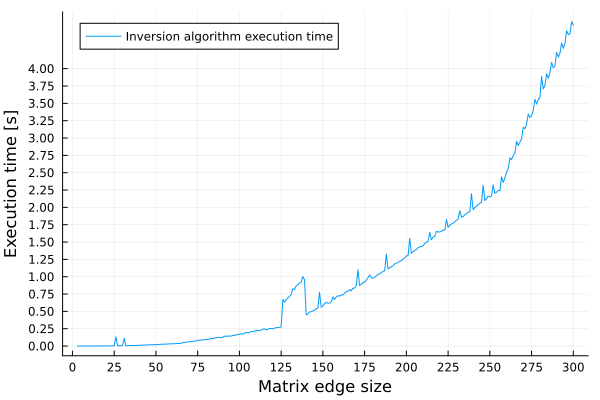

In [25]:
@df inv_df plot(:n, :execution_time, label="Inversion algorithm execution time", xlabel="Matrix edge size", ylabel="Execution time [s]", xticks=0:25:300, yticks=0:0.25:4)

In [27]:
savefig("inversion_exec_time_i5_13400f.png");

##### Wykres liczby operacji:

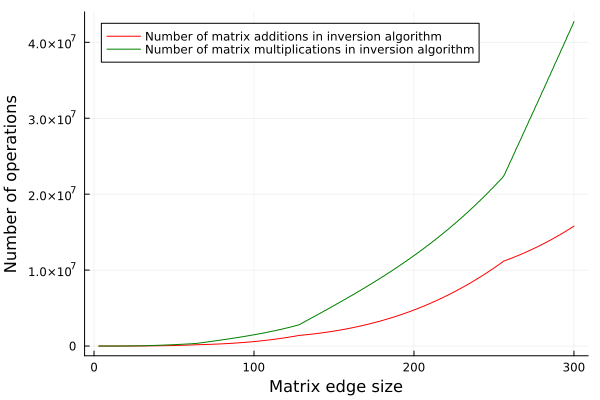

In [29]:
@df inv_df plot(:n, :additions, label="Number of matrix additions in inversion algorithm", xlabel="Matrix edge size", ylabel="Number of operations", color=:red)
@df inv_df plot!(:n, :multiplications, label="Number of matrix multiplications in inversion algorithm", color=:green)

In [31]:
savefig("inversion_number_of_add_and_mul_i5_13400f.png");

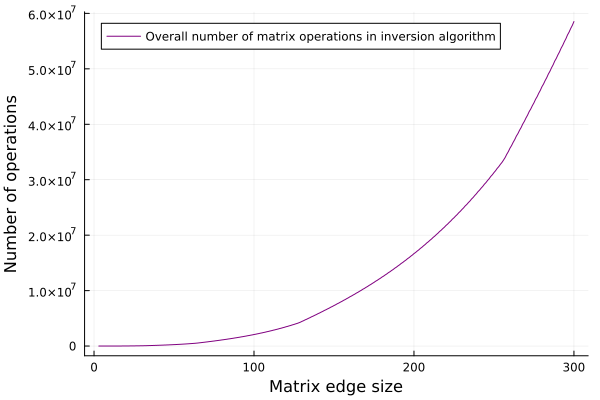

In [34]:
@df inv_df plot(:n, inv_df.additions+inv_df.multiplications, label="Overall number of matrix operations in inversion algorithm", xlabel="Matrix edge size", ylabel="Number of operations", color=:purple)

In [35]:
savefig("inversion_number_of_matrix_operations_i5_13400f.png");

### Rekurenycjny algorytm faktoryzacji LU:

Problem faktoryzacji LU jest często przedstawiany w następujący sposób:

$$ A = LU $$

gdzie:

$$ A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} $$

$$ L = \begin{bmatrix} L_{11} & 0 \\ L_{21} & L_{22} \end{bmatrix} $$

$$ U = \begin{bmatrix} U_{11} & U_{12} \\ 0 & U_{22} \end{bmatrix} $$

gdzie przez 0 w powyższych wzorach rozumiemy macierz wypełnioną 0.

Z uwagi na definicję faktoryzacji należy zaznaczyć, że macierz A musi być macierzą kwadratową, a zarówno L, jak i U muszą mieć takie same kształty co A.

Wprowadzamy również zapis funkcji faktoryzacji zwracającej macierze L oraz U:

$$ [L, U] = LU_{fact}(A) $$

Po wymnożeniu macierzy L i U otrzymujemy:

$$ LU = \begin{bmatrix} L_{11} U_{11} & L_{11} U_{12} \\ L_{21} U_{11} & L_{21} U_{12} + L_{22} U_{22} \end{bmatrix} $$

Przyrównajmy podmacierze z macierzy wynikowej do podmacierzy macierzy A:

$$ \text{I: } A_{11} = L_{11} U_{11} $$

$$ \text{II: } A_{12} = L_{11} U_{12} $$

$$ \text{III: } A_{21} = L_{21} U_{11} $$

$$ \text{IV: } A_{22} = L_{21} U_{12} + L_{22} U_{22} $$

Znalezienie podmacierzy L i U odbywa się następująco:

$$ \text{1: } [L_{11}, U_{11}] = LU_{fact}(A_{11}) $$

$$ \text{2: Mnożenie obustronne I przez } L_{11}^{-1} \text{ (lewostronne): } L_{11}^{-1} A_{11} = L_{11}^{-1} L_{11} U_{11} \implies U_{11} = L_{11}^{-1} A_{11} $$

$$ \text{3: Mnożenie obustronne II przez } L_{11}^{-1} \text{ (lewostronne): } L_{11}^{-1} A_{12} = L_{11}^{-1} L_{11} U_{12} \implies U_{12} = L_{11}^{-1} A_{12} $$

$$ \text{4: Mnożenie obustronne III przez } U_{11}^{-1} \text{ (prawostronne): } A_{21} U_{11}^{-1} = L_{21} U_{11} U_{11}^{-1} \implies L_{21} = A_{21} U_{11}^{-1} $$

$$ \text{5: Odjęcie obustrone } L_{21} U_{12} \text{ w IV: } L_{22} U_{22} = A_{22} - L_{21} U_{12} \implies L_{22} U_{22} = A_{22} - A_{21} U_{11}^{-1} L_{11}^{-1} A_{12} $$ 

$$ \text{6: } [L_{22}, U_{22}] = LU_{fact}(L_{22} U_{22}) $$

Mając na uwadze punkty I-IV, 1-6 oraz własności problemu faktoryzacji LU ustalamy jakie kształty powinny mieć podmacierze A, L oraz U: